In [1]:
from data import LipsyncDataset
import torch
from torch import nn
from data import AudioMFCC
import matplotlib.pyplot as plt
import torchaudio
import numpy as np
from torch import Tensor
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram
import torchaudio.functional as F

In [2]:
dataset = LipsyncDataset('../data/lipsync.parquet')

In [3]:
audio_raw = dataset[0]['audio']
audio_mfcc = AudioMFCC()({ 'audio': audio_raw, 'visemes': [] })['audio']

/home/nwhitehead/projects/lipsync/venv/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [4]:
audio_raw.shape, audio_mfcc.shape, audio_raw.shape[0] / 16000 / (10e-3)

(torch.Size([53867]), torch.Size([26, 335]), 336.66875)

In [5]:
def plot_spectrogram(specgram, title=None, xlabel="time", ylabel="freq"):
    _, ax = plt.subplots(1, 1)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

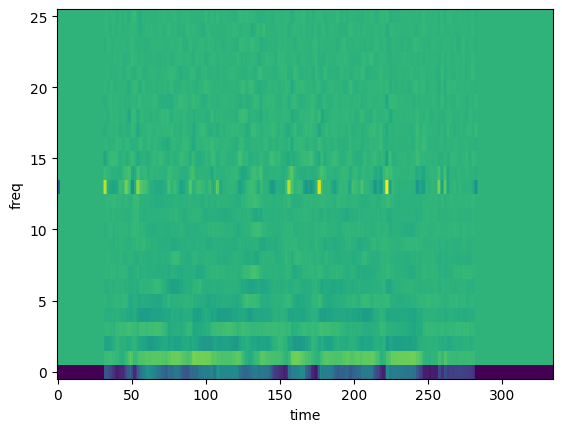

In [16]:
plot_spectrogram(audio_mfcc)

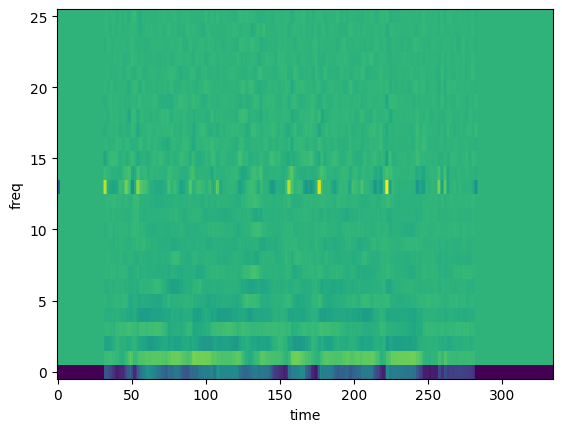

In [19]:
plot_spectrogram(mfcc(audio_raw))

In [98]:
m = mfcc(audio_raw)[17, :]
m.min(), m.max()

(tensor(-3039.5503), tensor(-0.0005))

In [14]:
class CustomMFCC(torch.nn.Module):
    r"""Create the Mel-frequency cepstrum coefficients from an audio signal.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    By default, this calculates the MFCC on the DB-scaled Mel spectrogram.
    This is not the textbook implementation, but is implemented here to
    give consistency with librosa.

    This output depends on the maximum value in the input spectrogram, and so
    may return different values for an audio clip split into snippets vs. a
    a full clip.

    Args:
        sample_rate (int, optional): Sample rate of audio signal. (Default: ``16000``)
        n_mfcc (int, optional): Number of mfc coefficients to retain. (Default: ``40``)
        dct_type (int, optional): type of DCT (discrete cosine transform) to use. (Default: ``2``)
        norm (str, optional): norm to use. (Default: ``"ortho"``)
        log_mels (bool, optional): whether to use log-mel spectrograms instead of db-scaled. (Default: ``False``)
        melkwargs (dict or None, optional): arguments for MelSpectrogram. (Default: ``None``)

    Example
        >>> waveform, sample_rate = torchaudio.load("test.wav", normalize=True)
        >>> transform = transforms.MFCC(
        >>>     sample_rate=sample_rate,
        >>>     n_mfcc=13,
        >>>     melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False},
        >>> )
        >>> mfcc = transform(waveform)

    See also:
        :py:func:`torchaudio.functional.melscale_fbanks` - The function used to
        generate the filter banks.
    """
    __constants__ = ["sample_rate", "n_mfcc", "dct_type", "top_db", "log_mels"]

    def __init__(
        self,
        sample_rate: int = 16000,
        n_mfcc: int = 40,
        dct_type: int = 2,
        norm: str = "ortho",
        log_mels: bool = False,
        melkwargs = None,
    ) -> None:
        super().__init__()
        supported_dct_types = [2]
        if dct_type not in supported_dct_types:
            raise ValueError("DCT type not supported: {}".format(dct_type))
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        self.dct_type = dct_type
        self.norm = norm
        self.top_db = 80.0
        self.amplitude_to_DB = AmplitudeToDB("power", self.top_db)

        melkwargs = melkwargs or {}
        self.MelSpectrogram = MelSpectrogram(sample_rate=self.sample_rate, **melkwargs)

        if self.n_mfcc > self.MelSpectrogram.n_mels:
            raise ValueError("Cannot select more MFCC coefficients than # mel bins")
        dct_mat = F.create_dct(self.n_mfcc, self.MelSpectrogram.n_mels, self.norm)
        self.register_buffer("dct_mat", dct_mat)
        self.log_mels = log_mels

    def forward(self, waveform: Tensor) -> Tensor:
        r"""
        Args:
            waveform (Tensor): Tensor of audio of dimension (..., time).

        Returns:
            Tensor: specgram_mel_db of size (..., ``n_mfcc``, time).
        """
        mel_specgram = self.MelSpectrogram(waveform)
        if self.log_mels:
            log_offset = 1e-6
            mel_specgram = torch.log(mel_specgram + log_offset)
        else:
            mel_specgram = self.amplitude_to_DB(mel_specgram)

        # (..., time, n_mels) dot (n_mels, n_mfcc) -> (..., n_nfcc, time)
        mfcc = torch.matmul(mel_specgram.transpose(-1, -2), self.dct_mat).transpose(-1, -2)
        return mfcc

In [18]:
def mfcc(samples, audio_rate=16000, num_mels=13, window_time=25e-3, hop_time=10e-3):
    window_length = round(window_time * audio_rate)
    hop_length = round(hop_time * audio_rate)
    melkwargs = {
        "n_fft": window_length,
        "win_length": window_length,
        "hop_length": hop_length,
        "center": False,
    }
    a = CustomMFCC(sample_rate=audio_rate, n_mfcc=num_mels, norm=None, melkwargs=melkwargs)(samples)
    d = np.array([0.5, 0.5, -0.5, -0.5])
    x = a.numpy()
    delta_a = np.apply_along_axis(np.convolve, axis=1, arr=x, v=d, mode='same')
    # Stack everything
    return torch.cat((a, torch.tensor(delta_a))).to(torch.float)


In [85]:
(mfcc(audio_raw) - audio_mfcc).sum()

tensor(-1852575.)

In [78]:
def mfcc(samples, audio_rate=16000, num_mels=13, window_time=25e-3, hop_time=10e-3):
    window_length = round(window_time * audio_rate)
    hop_length = round(hop_time * audio_rate)
    melkwargs = {
        "n_fft": window_length,
        "win_length": window_length,
        "hop_length": hop_length,
        "center": False,
    }
    n = len(range(0, samples.shape[0] - window_length, hop_length))
    a = torch.zeros(num_mels, n)
    mfcc_t = torchaudio.transforms.MFCC(sample_rate=audio_rate, n_mfcc=num_mels, melkwargs=melkwargs, norm=None)
    mfcc1_t = torchaudio.transforms.MFCC(sample_rate=audio_rate, n_mfcc=num_mels, melkwargs={
        "n_fft": window_length,
        "win_length": window_length,
        "hop_length": window_length + 1,
        "center": False,
    }, norm=None)
    for i in range(n):
        offset = i * hop_length
        slc = torch.zeros(window_length)
        slc[:min(window_length, samples.shape[0] - offset)] = samples[offset:offset + window_length]
        slc_m = mfcc1_t(slc)
        a[:, i] = slc_m[:, 0]
    b = mfcc_t(samples[:10000])
    print(b[:, 0])
    d = np.array([0.5, 0.5, -0.5, -0.5])
    x = a.numpy()
    delta_a = np.apply_along_axis(np.convolve, axis=1, arr=x, v=d, mode='same')
    # Stack everything
    #return torch.cat((torch.tensor(delta_a), a)).to(torch.float)
    return a

mfcc(audio_raw)[:, 0], audio_mfcc[-13:, 0]

tensor([-1.5653e+04,  1.0482e-05, -6.4499e-04,  1.8657e-04, -6.1056e-04,
         6.2670e-05, -9.9637e-05, -1.2951e-03,  5.4336e-05,  1.5854e-03,
        -4.6990e-04,  6.6618e-04, -7.0296e-05])


(tensor([-2.5600e+04,  2.4414e-04, -9.7656e-04,  7.3242e-04, -8.5449e-04,
          2.4414e-04,  1.2207e-04, -2.0142e-03, -2.7466e-04,  2.7237e-03,
         -1.0071e-03,  1.0986e-03, -3.2043e-04]),
 tensor([-1.3312e+04,  9.7848e-05, -1.0291e-04,  4.1047e-04, -2.0134e-04,
          2.1413e-04, -2.3665e-04, -1.1831e-03, -2.0740e-04,  1.3749e-03,
         -5.2748e-04,  4.9088e-04, -1.1258e-04]))